# Part 3: Validation

In [ ]:
%%capture
%pip install python-terrier

import pyterrier as pt
import pandas as pd
import numpy as np
import tqdm
from utils import preprocess

pt.init()

In [ ]:
"""import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64/"
"""

In [ ]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

    pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False, overwrite=True)
    pd_indexer.setProperty("termpipelines", "")
    pd_indexer.setProperty("metaindex.compressed.reverse.allow.duplicates", "true")

    if mode == "title":
        index_ref = pd_indexer.index(docs_df["title"], docs_df["docno"])
    elif mode == "abstract":
        index_ref = pd_indexer.index(docs_df["abstract"], docs_df["docno"])
    else:  # both or else
        index_ref = pd_indexer.index(docs_df["title"], docs_df["abstract"], docs_df["docno"])

    return index_ref

def index_model(index, model="TF_IDF"):
    """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH",
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
    """
    list_model = ["TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", "BM25"]

    indexing_model = pt.BatchRetrieve(index, wmodel=model)
    return indexing_model

def preprocess_queries(queries):
    queries_preprocessed = queries.copy()
    for index, row in tqdm(queries.iterrows(), total=len(queries)):
        queries_preprocessed.loc[index, "title"] = " ".join(preprocess(row["title"]))
        queries_preprocessed.loc[index, "description"] = " ".join(
            preprocess(row["description"])
        )
        queries_preprocessed.loc[index, "narrative"] = " ".join(
            preprocess(row["narrative"])
        )

    queries_preprocessed.to_pickle("data/queries_processed.pkl")

def expirement(indexed_docs, preprocessed_query, qrels):
    tfidf = index_model(indexed_docs, model="TF_IDF")
    bm25 = index_model(indexed_docs, model="BM25")
    dirichlet_lm = index_model(indexed_docs, model="DirichletLM")

    exp = pt.Experiment(
        [tfidf, bm25, dirichlet_lm],
        preprocessed_query,
        qrels,
        eval_metrics=[P@5, P@10, nDCG@10, RR(rel=2)],
        names=["TF_IDF", "BM25", "DirichletLM"]
    )
    return exp

# Experiments
# - preprocessing: {all languages, only english}
# - topics: {title, description, narrative}
# - indexing: {title, abstract, both}
# - models: {tf_idf, bm25, dirichlet_lm}

In [ ]:
# read preprocessed en-documents
en_docs = pd.read_pickle('./data/en_docs_processed.pkl')
en_docs.rename(columns={"doc_id":"docno"}, inplace=True)

# index en-documents by (title, abstract, both)
index_ref_en_docs_title = create_index(en_docs, mode="title", indexer_path="./indexes/title")
index_en_docs_title = pt.IndexFactory.of(index_ref_en_docs_title)

index_ref_en_docs_abstract = create_index(en_docs, mode="abstract", indexer_path="./indexes/abstract")
index_en_docs_abstract = pt.IndexFactory.of(index_ref_en_docs_abstract)

index_ref_en_docs_both = create_index(en_docs, mode="both", indexer_path="./indexes/both")
index_en_docs_both = pt.IndexFactory.of(index_ref_en_docs_both)

In [ ]:
# read preprocessed documents
docs = pd.read_pickle('./data/docs_processed.pkl')
docs.rename(columns={"doc_id":"docno"}, inplace=True)

# index documents by (title, abstract, both)
index_ref_docs_title = create_index(docs, mode="title", indexer_path="./indexes/title")
index_docs_title = pt.IndexFactory.of(index_ref_docs_title)

index_ref_docs_abstract = create_index(docs, mode="abstract", indexer_path="./indexes/abstract")
index_docs_abstract = pt.IndexFactory.of(index_ref_docs_abstract)

index_ref_docs_both = create_index(docs, mode="both", indexer_path="./indexes/both")
index_docs_both = pt.IndexFactory.of(index_ref_docs_title)

In [ ]:
# preprocess queries by (title, description, narrative)
queries = pd.read_pickle('./data/queries_processed.pkl')
queries = preprocess_queries(queries)

pq_title = queries[['query_id', 'title']]
pq_title = pq_title.rename(columns={'query_id':'qid', 'title':'query'})
display(pq_title.head(5))

pq_desc = queries[['query_id', 'description']]
pq_desc = pq_desc.rename(columns={'query_id':'qid', 'description':'query'})
display(pq_desc.head(5))

pq_narr = queries[['query_id', 'narrative']]
pq_narr = pq_narr.rename(columns={'query_id':'qid', 'narrative':'query'})
display(pq_narr.head(5))

# load trec-covid dataset
cord19 = pt.get_dataset("irds:cord19/trec-covid")

In [ ]:
# en_docs {title, abstract, both} with query_title
exp1 = expirement(index_en_docs_title, pq_title, cord19.qrels())
display(exp1)

exp2 = expirement(index_en_docs_abstract, pq_title, cord19.qrels())
display(exp2)

exp3 = expirement(index_en_docs_both, pq_title, cord19.qrels())
display(exp3)

# en_docs {title, abstract, both} with query_description
exp4 = expirement(index_en_docs_title, pq_desc, cord19.qrels())
display(exp4)

exp5 = expirement(index_en_docs_abstract, pq_desc, cord19.qrels())
display(exp5)

exp6 = expirement(index_en_docs_both, pq_desc, cord19.qrels())
display(exp6)

# en_docs {title, abstract, both} with query_narrative
exp7 = expirement(index_en_docs_title, pq_narr, cord19.qrels())
display(exp7)

exp8 = expirement(index_en_docs_abstract, pq_narr, cord19.qrels())
display(exp8)

exp9 = expirement(index_en_docs_both, pq_narr, cord19.qrels())
display(exp9)

In [ ]:
# docs {title, abstract, both} with query_title
exp1 = expirement(index_docs_title, pq_title, cord19.qrels())
display(exp1)

exp2 = expirement(index_docs_abstract, pq_title, cord19.qrels())
display(exp2)

exp3 = expirement(index_docs_both, pq_title, cord19.qrels())
display(exp3)

# docs {title, abstract, both} with query_description
exp4 = expirement(index_docs_title, pq_desc, cord19.qrels())
display(exp4)

exp5 = expirement(index_docs_abstract, pq_desc, cord19.qrels())
display(exp5)

exp6 = expirement(index_docs_both, pq_desc, cord19.qrels())
display(exp6)

# docs {title, abstract, both} with query_narrative
exp7 = expirement(index_docs_title, pq_narr, cord19.qrels())
display(exp7)

exp8 = expirement(index_docs_abstract, pq_narr, cord19.qrels())
display(exp8)

exp9 = expirement(index_docs_both, pq_narr, cord19.qrels())
display(exp9)

# Pairwise Similarity of Queries
# - TF-IDF
# - DOC2VEC

Write a function that measures the pairwise similarity of the provided 
queries. Create a list of similar queries and a word-cloud of their qids.

In [15]:
%%capture
%pip install gensim

import pandas as pd
import numpy as np
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def compute_freqs(queries, labels):
    freqs = {}
    for i in range(max(labels)):
        # print(f"cluster {i:2} {queries.loc[labels==i]['title'].values}")

        similar_queries = queries.loc[labels==i]['query_id'].values
        for qid in similar_queries:
            freqs[qid] = len(similar_queries)

    return freqs

def print_clustered_queries(queries, labels):
    for i in range(max(labels)):
        print(f"cluster {i:2} {queries.loc[labels==i]['description'].values}")

In [16]:
queries = pd.read_pickle('./data/queries_processed.pkl')

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(queries['description']).toarray()

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.9)
labels = cluster.fit_predict(vectors)

print_clustered_queries(queries, labels)

cluster  0 ['covid19 pandemic impact violence society include violent crime'
 'covid19 pandemic impact mental health'
 'health outcome child contract covid19'
 'benefit risk reopen school midst covid19 pandemic']
cluster  1 ['coronavirus respond change weather'
 'serological test detect antibody coronavirus'
 'transmission route coronavirus' 'long coronavirus live outside body'
 'long coronavirus remain stable surface']
cluster  2 ['evidence relate covid19 super spreader'
 'evidence value hydroxychloroquine treat covid19'
 'remdesivir effective treatment covid19'
 'vitamin impact covid19 prevention treatment'
 'evidence dexamethasone treatment covid19']
cluster  3 ['cardiac complication likely patient covid19'
 'kind complication related covid19 associate hypertension'
 'kind complication related covid19 associate diabetes'
 'longerterm complication recover covid19']
cluster  4 ['social distance impact slow spread covid19'
 'best mask prevent infection covid19'
 'much impact mask preve

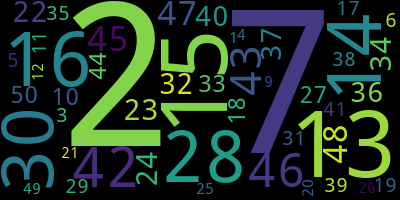

In [17]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()

In [18]:
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(queries['description'])]
doc_model = Doc2Vec(tagged_data, window=5, seed=1)
d2v_doc_embeddings = np.array([doc_model.infer_vector(doc.split()) for doc in queries['description']])
print(d2v_doc_embeddings.shape)

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.8)
labels = cluster.fit_predict(d2v_doc_embeddings)

print_clustered_queries(queries, labels)

(50, 100)
cluster  0 ['patient take angiotensinconverting enzyme inhibitor ace increase risk covid19'
 'result phylogenetic analysis sarscov2 genome sequence']
cluster  1 ['coronavirus respond change weather' 'covid19 affect canada'
 'initial symptom covid19']
cluster  2 ['know infected covid19 asymptomatic'
 'observed mutation sarscov2 genome often mutation occur']
cluster  3 ['transmission route coronavirus' 'protein structure sarscov2 spike']
cluster  4 ['sarscov2 proteinshuman proteins interaction indicate potential drug target approve drug repurposed base information'
 'remdesivir effective treatment covid19']
cluster  5 ['impact covid19 among africanamericans differ rest u population'
 'health outcome child contract covid19']
cluster  6 ['vaccine candidate test covid19'
 'individual recover covid19 show sufficient immune response include antibody level tcell mediate immunity prevent reinfection']
cluster  7 ['sarscov2 subtypes' 'mechanism cytokine storm syndrome covid19']
cluster

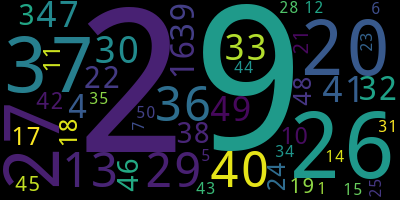

In [19]:
wordcloud.WordCloud().fit_words(compute_freqs(queries, labels)).to_image()